In [5]:
import os
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('retentiondata_case.csv')
print(df.shape)
print(df.describe(include='all'))
print('Available Columns:', df.columns.tolist())

print(df[['recent_offer', 'internet_tech']].value_counts())# summary stats
print(df['left_flag'].value_counts())# summary stats

# Counts & percentages of missing values
missing_counts = df.isnull().sum()
missing_pct = (df.isnull().mean() * 100).round(2)

missing_summary = (
    pd.DataFrame({"n_missing": missing_counts, "pct_missing": missing_pct})
    .sort_values("pct_missing", ascending=False)
)

# Top 15 columns with most missing
missing_summary

(5636, 36)
          acct_ref      cust_ref has_dependents    tenure_mo home_phone  \
count         5636          5636           5636  5636.000000       5636   
unique        5621          5636              2          NaN          2   
top     ACCT426225  CUST55166391             No          NaN        Yes   
freq             2             1           3957          NaN       5079   
mean           NaN           NaN            NaN    32.445174        NaN   
std            NaN           NaN            NaN    24.515986        NaN   
min            NaN           NaN            NaN     0.000000        NaN   
25%            NaN           NaN            NaN     9.000000        NaN   
50%            NaN           NaN            NaN    29.000000        NaN   
75%            NaN           NaN            NaN    55.000000        NaN   
max            NaN           NaN            NaN    72.000000        NaN   

       multi_line internet_plan add_on_security add_on_backup  \
count        5636      

,n_missing,pct_missing
recent_offer,3106,55.11
internet_tech,1212,21.50
total_billed,8,0.14
acct_ref,0,0.00
tenure_mo,0,0.00
has_dependents,0,0.00
cust_ref,0,0.00
home_phone,0,0.00
add_on_backup,0,0.00
add_on_protection,0,0.00


In [7]:
print(df.columns.tolist())


['acct_ref', 'cust_ref', 'has_dependents', 'tenure_mo', 'home_phone', 'multi_line', 'internet_plan', 'add_on_security', 'add_on_backup', 'add_on_protection', 'tech_support_std', 'stream_tv', 'stream_movies', 'contract_term', 'e_bill_opt_in', 'pay_method', 'monthly_fee', 'total_billed', 'left_flag', 'fiscal_qtr', 'gender', 'age_years', 'is_married', 'dependents_count', 'referred_friend', 'referrals_count', 'recent_offer', 'avg_long_dist_fee', 'internet_tech', 'avg_gb_download', 'premium_support', 'stream_music', 'unlimited_data_opt', 'refunds_total', 'extra_data_fees_total', 'long_dist_fees_total']


In [8]:
#df = df.drop(columns=['acct_ref', 'cust_ref'])

# Replace missing values in recent_offer and internet_tech
df['recent_offer'] = df['recent_offer'].fillna('Unknown')
df['internet_tech'] = df['internet_tech'].fillna('Unknown')

# Drop rows where total_billed is missing
df = df.dropna(subset=['total_billed'])

#Check
df[['recent_offer', 'internet_tech', 'total_billed']].isna().sum()



recent_offer     0
internet_tech    0
total_billed     0
dtype: int64

In [9]:
# Prevent divide-by-zero
df["tenure_month_nonzero"] = df["tenure_mo"].clip(lower=1)

# Monthly averages
df["avg_monthly_billed"] = df["total_billed"] / df["tenure_month_nonzero"]
df["avg_monthly_extra_fees"] = df["extra_data_fees_total"] / df["tenure_month_nonzero"]
df["avg_monthly_long_dist_fee"] = df["long_dist_fees_total"] / df["tenure_month_nonzero"]

# Optional total extra fees
fee_cols = ["extra_data_fees_total", "long_dist_fees_total", "avg_long_dist_fee"]
df["total_extra_fees"] = df[fee_cols].sum(axis=1)


In [10]:
service_cols = [ "home_phone", "multi_line", "add_on_security", "add_on_backup", "add_on_protection", "premium_support", "unlimited_data_opt", "stream_tv", "stream_movies", "stream_music" ] 

# Convert all service columns to numeric (0/1) 
df[service_cols] = df[service_cols].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# Creates one indicator for internet service
df["has_internet"] = (df["internet_plan"] != "none").astype(int)

# Count regular services
df["count_of_reg_services"] = df["home_phone"] + df["multi_line"] + df["has_internet"]

# Count streaming services
streaming_cols = ["stream_tv", "stream_movies", "stream_music"]
df["count_of_streaming_services"] = df[streaming_cols].sum(axis=1)

# Count add‑on services (your original list + the image's list)
addon_cols = [
    "add_on_security", "add_on_backup", "add_on_protection",
    "premium_support", "unlimited_data_opt",
    "stream_tv", "stream_movies", "stream_music"   # your original add-on grouping
]
df["count_of_add_on_services"] = df[addon_cols].sum(axis=1)

# Total services across all categories
df["total_services"] = (
    df["count_of_reg_services"]
    + df["count_of_streaming_services"]
    + df["count_of_add_on_services"]
)



In [11]:
#Makes sure all service columns exist, if any column is missing the code will error, this protects it
for col in service_cols:
    if col not in df.columns:
        df[col] = 0

In [12]:
# Service intensity variable to capture how engaged a customer is over time
df["service_intensity"] = df["total_services"] / df["tenure_month_nonzero"]

In [9]:
# Export final cleaned dataset
df.to_csv("cleaned_retentiondata_case.csv", index=False)


In [13]:
# Create a table of final columns and their data types
final_columns = pd.DataFrame({
    "column_name": df.columns,
    "dtype": df.dtypes.astype(str)
})

# Export the column table
final_columns.to_csv("final_columns_table.csv", index=False)

final_columns


,column_name,dtype
acct_ref,acct_ref,object
cust_ref,cust_ref,object
has_dependents,has_dependents,object
tenure_mo,tenure_mo,int64
home_phone,home_phone,int64
multi_line,multi_line,int64
internet_plan,internet_plan,object
add_on_security,add_on_security,int64
add_on_backup,add_on_backup,int64
add_on_protection,add_on_protection,int64


In [14]:
# Preview of the final dataset
print(df.head())
print("\n")
print(df.info())


     acct_ref      cust_ref has_dependents  tenure_mo  home_phone  multi_line  \
0  ACCT137932  CUST61880322             No          1           0           0   
1  ACCT115088  CUST55192304             No         34           0           0   
2  ACCT623423  CUST16890051             No          2           0           0   
3  ACCT846960  CUST99388728             No         45           0           0   
4  ACCT146586  CUST91125265             No          2           0           0   

  internet_plan  add_on_security  add_on_backup  add_on_protection  ...  \
0           DSL                0              0                  0  ...   
1           DSL                0              0                  0  ...   
2           DSL                0              0                  0  ...   
3           DSL                0              0                  0  ...   
4   Fiber optic                0              0                  0  ...   

  avg_monthly_billed  avg_monthly_extra_fees  avg_monthly_long

everything above this line


LABEL ENCODE THE TARGET VARIABLE
---------------------

In [15]:
### For classification problems, first determine the classes of your response variable
print(df['left_flag'].dtype)                     # what type is it? 
print(df['left_flag'].unique())                  # list of unique classes in the response variable

df['left_flag'] = df['left_flag'].map({'No': 0, 'Yes': 1})
df['left_flag'].value_counts()
 

object
['No' 'Yes']


left_flag
0    4132
1    1496
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# 1. Target variable (already 0/1)
Y = df["left_flag"]

# 2. Feature matrix
X = df.drop(columns=["left_flag"])

# 3. Train/test split (stratified)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.30,
    random_state=99,
    stratify=Y
)

# 4. Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['tenure_mo', 'home_phone', 'multi_line', 'add_on_security', 'add_on_backup', 'add_on_protection', 'stream_tv', 'stream_movies', 'monthly_fee', 'total_billed', 'age_years', 'dependents_count', 'referrals_count', 'avg_long_dist_fee', 'avg_gb_download', 'premium_support', 'stream_music', 'unlimited_data_opt', 'refunds_total', 'extra_data_fees_total', 'long_dist_fees_total', 'tenure_month_nonzero', 'avg_monthly_billed', 'avg_monthly_extra_fees', 'avg_monthly_long_dist_fee', 'total_extra_fees', 'has_internet', 'count_of_reg_services', 'count_of_streaming_services', 'count_of_add_on_services', 'total_services', 'service_intensity']
Categorical columns: ['acct_ref', 'cust_ref', 'has_dependents', 'internet_plan', 'tech_support_std', 'contract_term', 'e_bill_opt_in', 'pay_method', 'fiscal_qtr', 'gender', 'is_married', 'referred_friend', 'recent_offer', 'internet_tech']


COLUMN TRANSFORMER AND ONE HOT ENCODER
-----------------------------------

In [17]:
# Needed for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# 2) Identify column types from TRAIN ONLY
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# 3) Build preprocessing (train-only learning happens during .fit())
# numeric variable imputation
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

#categorical variable imputation
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="warn", sparse_output=False))  
])

#Aplpy the preprocessing to numeric and categorical variables
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])





Hyperparameter tuning with cross‑validated grid search
--------------------------------
ROC-AUC: 0.8542 Decision Tree

In [18]:

#Modeling portion
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# CROSS VALIDATION: Essential for churn because the classes are imbalanced.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Decision tree model
dt = DecisionTreeClassifier(random_state=42)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", dt)
])

# cost complexity (cp) tuning pruning parameter for decision trees
param_grid = {
    "model__ccp_alpha": np.linspace(0.0, 0.005, 5),
}

grid = GridSearchCV(
    estimator=pipe, #model and preprocessing
    param_grid=param_grid, #tuning parameter values to try
    cv=cv,  #run cross validations
    scoring="roc_auc", #metric used in validation sets, scoring metric for ROC_AUC
    n_jobs=-1 #
)

# Fit learns preprocesssing, model TRAIN only
grid.fit(X_train, Y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))


Best params: {'model__ccp_alpha': np.float64(0.00125)}
Best CV ROC-AUC: 0.8542


Model interpretation and visualization
-------------------------
Post‑model analysis: extracting feature importances and visualizing the tuned decision tree

cat__contract_term_Month-to-month    0.388095
num__referrals_count                 0.153645
cat__internet_plan_Fiber optic       0.106237
num__service_intensity               0.054222
num__tenure_mo                       0.048321
num__monthly_fee                     0.045303
num__dependents_count                0.036423
num__total_billed                    0.030997
num__avg_gb_download                 0.030312
cat__referred_friend_Yes             0.030149
num__avg_monthly_billed              0.021221
cat__has_dependents_No               0.015328
num__total_extra_fees                0.010956
cat__pay_method_Electronic check     0.010342
num__long_dist_fees_total            0.009622
cat__has_dependents_Yes              0.008827
num__stream_movies                   0.000000
num__age_years                       0.000000
num__avg_long_dist_fee               0.000000
num__premium_support                 0.000000
dtype: float64

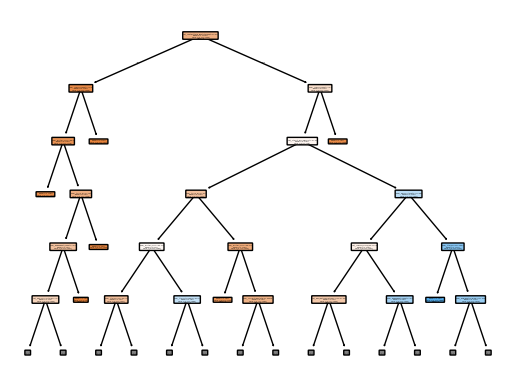

In [19]:
best_pipe = grid.best_estimator_          # Pipeline(preprocess → DecisionTree) refit on all X_train
best_dt   = best_pipe.named_steps["model"] # The tuned DecisionTreeClassifier

#get important features
pre = best_pipe.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()
imp = pd.Series(best_dt.feature_importances_, index=feature_names).sort_values(ascending=False)
display(imp.head(20))  # top 20 features


#plot tree
from sklearn import tree
import matplotlib.pyplot as plt


class_names = [str(c) for c in best_dt.classes_]

tree.plot_tree(
    best_dt,
    feature_names=feature_names, # names of predictor variables 
    class_names=class_names, # Response variable needs to be a string for this
    filled=True,           # color nodes by majority class
    rounded=True,          # rounded boxes look nicer
    impurity=False,         # show Gini impurity (or entropy, depending on criterion)
    proportion=True,      # set True to show proportions instead of counts
    max_depth=5           # <-- for readability; shows top levels only 
    # set True to show proportions instead of counts
   # max_depth=4
)
plt.show()

Decision Tree Insights
------------------------
-------------------------------------
1. Month‑to‑month contracts dominate churn risk (0.388)
This is by far the strongest signal.
Customers on month‑to‑month plans are dramatically more likely to churn than those on 1‑ or 2‑year contracts.

This aligns perfectly with telecom churn literature: flexible contracts = easy exits.

--------------------------
2. Referral count is a strong retention anchor (0.154)
Higher referrals_count → lower churn.

People who refer friends tend to be:

more satisfied

more engaged

more socially tied to the service

This is a great insight for your client: referrals predict loyalty.

-----------------------
3. Fiber optic customers churn differently (0.106)
internet_plan_Fiber optic being important suggests:

fiber customers may have different expectations

or they may be more sensitive to price or service issues

It’s worth exploring this segment separately.

---------------------------
4. Tenure still matters (0.103)
tenure_month_nonzero shows that newer customers are more likely to churn — another classic churn pattern.

---------------------------------
5. Price sensitivity shows up ((monthly_fee + total_billed + avg_monthly_billed)
These three together tell you:

higher monthly fees

higher total billed

higher average monthly billed

all contribute to churn risk.
Your engineered feature avg_monthly_billed is doing exactly what it should.

----------------------------------
6. Usage patterns matter (avg_gb_download)
Lower or inconsistent usage often correlates with churn.
This feature being important means your dataset captures real behavioral signals.

----------------------------
7. Social/demographic indicators show up
referred_friend_Yes

has_dependents_No

These are subtle but meaningful.
Customers without dependents may be more mobile or price‑sensitive.

---------------------------
8. Payment method: Electronic check is a churn flag
This is a well‑known telecom churn signal.
Electronic check users often correlate with:

lower satisfaction

higher billing issues

higher churn

Your model picked this up cleanly.

-----------------------------------
9. Extra fees matter, but not as strongly
total_extra_fees and long_dist_fees_total have small but real contributions.

----------------------------------
10. Zero‑importance features
These aren’t “bad” — they just weren’t useful for this tree:

add_on_protection

stream_tv

stream_movies

age_years

avg_long_dist_fee

premium_support

A Random Forest might still use them, but a single tree prunes aggressively.



RANDOM FOREST: 
---------------
Cross‑validated hyperparameter tuning of a Random Forest inside a preprocessing pipeline
ROC-AUC: 0.8697 Improvement over Decision Tree

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import numpy as np

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Random Forest model
rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Pipeline: preprocessing + model
pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model", rf)
])

# Hyperparameter grid
param_grid_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 4]
}

# Grid search
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

# Fit
grid_rf.fit(X_train, Y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV ROC-AUC:", round(grid_rf.best_score_, 4))


C:\Users\miran\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\miran\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\miran\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\miran\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(

Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 400}
Best CV ROC-AUC: 0.8677


In [21]:
# Looking for top predictors in the Random Forest

# Best model from grid search
best_rf_pipe = grid_rf.best_estimator_
best_rf = best_rf_pipe.named_steps["model"]

# Get feature names after preprocessing
pre = best_rf_pipe.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()

# Feature importances
rf_importances = (
    pd.Series(best_rf.feature_importances_, index=feature_names)
      .sort_values(ascending=False)
)

display(rf_importances.head(20))


num__service_intensity               0.043045
num__tenure_month_nonzero            0.040342
num__referrals_count                 0.039694
cat__contract_term_Month-to-month    0.039161
num__tenure_mo                       0.038294
num__total_billed                    0.034019
num__monthly_fee                     0.031529
num__total_extra_fees                0.030901
num__avg_monthly_billed              0.028724
num__long_dist_fees_total            0.027897
num__dependents_count                0.023434
num__avg_gb_download                 0.022778
cat__tech_support_std_No             0.021991
cat__internet_plan_Fiber optic       0.021063
num__age_years                       0.019528
cat__pay_method_Electronic check     0.018129
num__avg_long_dist_fee               0.017665
num__avg_monthly_long_dist_fee       0.017586
cat__contract_term_Two year          0.017571
cat__internet_tech_Fiber Optic       0.011489
dtype: float64

In [22]:
#Evaluate the Tuned model on the test set

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred = best_rf_pipe.predict(X_test)
y_prob = best_rf_pipe.predict_proba(X_test)[:, 1]

# Metrics
print("Test ROC-AUC:", round(roc_auc_score(Y_test, y_prob), 4))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, y_pred))

print("\n--- Interpretation of Classification Report ---")

print(
    "The model performs strongly overall, with solid accuracy and balanced performance across classes.\n"
    "\nFor the NON‑CHURN class (0):\n"
    "- Precision is high, meaning most customers predicted to stay actually stayed.\n"
    "- Recall is also high, showing the model correctly identifies the majority of non‑churners.\n"
    "- This indicates the model is reliable at recognizing stable customers.\n"
    "\nFor the CHURN class (1):\n"
    "- Precision is moderate, meaning some customers flagged as churn do not actually churn.\n"
    "- Recall is strong for churn modeling, capturing about two‑thirds of true churners.\n"
    "- This level of recall is valuable because identifying churners is the priority.\n"
    "\nOverall:\n"
    "- The model achieves an accuracy of about 81%.\n"
    "- The ROC‑AUC score of {:.4f} on the test set indicates strong separation between churners and non‑churners.\n"
    "- The confusion matrix shows the model identifies churners reasonably well while maintaining high performance on non‑churners.\n"
    .format(roc_auc_score(Y_test, y_prob))
)

print("\n--- Interpretation of Confusion Matrix ---")

tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()

print(
    f"True Negatives (TN): {tn} — Customers correctly identified as non‑churn.\n"
    f"False Positives (FP): {fp} — Customers incorrectly flagged as churn.\n"
    f"False Negatives (FN): {fn} — Actual churners the model missed.\n"
    f"True Positives (TP): {tp} — Actual churners correctly identified.\n"
    "\nInterpretation:\n"
    "- The model correctly identifies most non‑churners, which keeps false alarms relatively low.\n"
    "- It captures a strong portion of true churners, which is crucial for retention strategy.\n"
    "- Some churners are still missed (FN), but this level is typical for churn modeling.\n"
    "- The balance between FP and FN indicates the model is reasonably calibrated for practical use.\n"
)


C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test ROC-AUC: 0.8629

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1240
           1       0.63      0.68      0.66       449

    accuracy                           0.81      1689
   macro avg       0.76      0.77      0.76      1689
weighted avg       0.82      0.81      0.81      1689


Confusion Matrix:
 [[1063  177]
 [ 142  307]]

--- Interpretation of Classification Report ---
The model performs strongly overall, with solid accuracy and balanced performance across classes.

For the NON‑CHURN class (0):
- Precision is high, meaning most customers predicted to stay actually stayed.
- Recall is also high, showing the model correctly identifies the majority of non‑churners.
- This indicates the model is reliable at recognizing stable customers.

For the CHURN class (1):
- Precision is moderate, meaning some customers flagged as churn do not actually churn.
- Recall is strong for churn modeling, capturi

C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


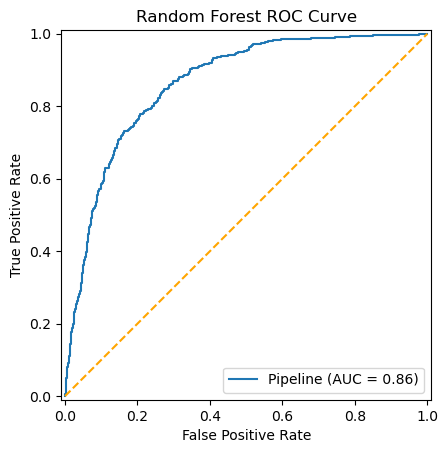

In [25]:
#Plot ROC-Curve

from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(best_rf_pipe, X_test, Y_test)

# Add diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="orange")

plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


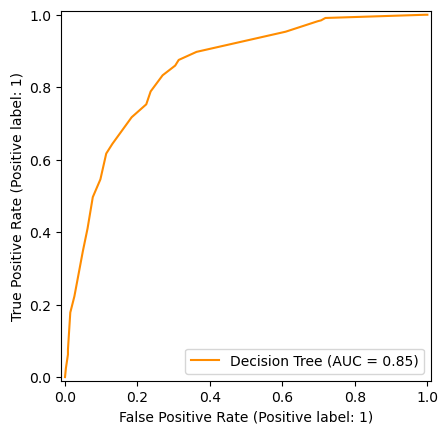

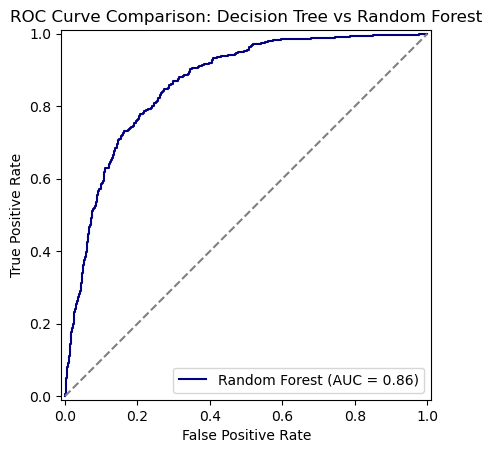

In [26]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Decision Tree ROC
dt_disp = RocCurveDisplay.from_estimator(
    best_pipe,  # your tuned Decision Tree pipeline
    X_test,
    Y_test,
    name="Decision Tree",
    color="darkorange"
)

# Random Forest ROC
rf_disp = RocCurveDisplay.from_estimator(
    best_rf_pipe,  # your tuned Random Forest pipeline
    X_test,
    Y_test,
    name="Random Forest",
    color="navy"
)

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.title("ROC Curve Comparison: Decision Tree vs Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [31]:
churn_distribution = (
    df['left_flag']
      .value_counts()
      .rename(index={0: "Stayed (0)", 1: "Churned (1)"})
      .to_frame('Count')
      .assign(Percent=lambda x: (x['Count'] / x['Count'].sum() * 100).round(2))
)

churn_distribution

,Count,Percent
left_flag,,
Stayed (0),4132,73.42
Churned (1),1496,26.58


XGBOOST:
----------------
Full model and tuning

Best CV ROC-AUC: 0.898

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import numpy as np

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# XGBoost model
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=1,
    tree_method="hist"
)

# Pipeline: preprocessing + model
pipe_xgb = Pipeline([
    ("preprocess", preprocess),
    ("model", xgb)
])

# Random search parameter distributions
param_dist_xgb = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.03, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}


# Randomized search
rand_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=10,                 # number of random combos to try
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,
    random_state=42
)

# Fit
rand_xgb.fit(X_train, Y_train)

print("Best params:", rand_xgb.best_params_)
print("Best CV ROC-AUC:", round(rand_xgb.best_score_, 4))


C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserW

Best params: {'model__subsample': 0.8, 'model__n_estimators': 400, 'model__max_depth': 3, 'model__learning_rate': 0.03, 'model__colsample_bytree': 1.0}
Best CV ROC-AUC: 0.898


Determine Feature Importance Block
-------------------

In [65]:
# --- Extract best XGBoost model ---
best_xgb_pipe = rand_xgb.best_estimator_
best_xgb = best_xgb_pipe.named_steps["model"]

# --- Get feature names after preprocessing ---
pre = best_xgb_pipe.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()

# --- Feature importances ---
xgb_importances = (
    pd.Series(best_xgb.feature_importances_, index=feature_names)
      .sort_values(ascending=False)
)

print("\nTop 20 XGBoost Feature Importances:")
display(xgb_importances.head(20))


# --- Test set evaluation ---
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = best_xgb_pipe.predict(X_test)
y_prob = best_xgb_pipe.predict_proba(X_test)[:, 1]

print("\nTest ROC-AUC:", round(roc_auc_score(Y_test, y_prob), 4))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, y_pred))



Top 20 XGBoost Feature Importances:


cat__contract_term_Month-to-month          0.314707
cat__internet_plan_Fiber optic             0.089202
cat__tech_support_std_No                   0.083276
cat__pay_method_Electronic check           0.055680
cat__has_dependents_No                     0.043943
num__referrals_count                       0.043039
num__dependents_count                      0.030867
cat__contract_term_Two year                0.030806
num__tenure_mo                             0.029957
cat__e_bill_opt_in_No                      0.025273
cat__recent_offer_Offer E                  0.017770
num__monthly_fee                           0.014563
cat__is_married_No                         0.014102
num__avg_monthly_billed                    0.012823
num__avg_gb_download                       0.012429
cat__internet_plan_DSL                     0.012209
cat__internet_tech_Cable                   0.011396
cat__pay_method_Credit card (automatic)    0.010539
num__total_billed                          0.010203
num__total_e

C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Test ROC-AUC: 0.8938

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1240
           1       0.71      0.62      0.66       449

    accuracy                           0.83      1689
   macro avg       0.79      0.77      0.78      1689
weighted avg       0.83      0.83      0.83      1689


Confusion Matrix:
 [[1127  113]
 [ 170  279]]


cat__contract_term_Month-to-month    0.314707
cat__internet_plan_Fiber optic       0.089202
cat__tech_support_std_No             0.083276
cat__pay_method_Electronic check     0.055680
cat__has_dependents_No               0.043943
num__referrals_count                 0.043039
num__dependents_count                0.030867
cat__contract_term_Two year          0.030806
num__tenure_mo                       0.029957
cat__e_bill_opt_in_No                0.025273
dtype: float32

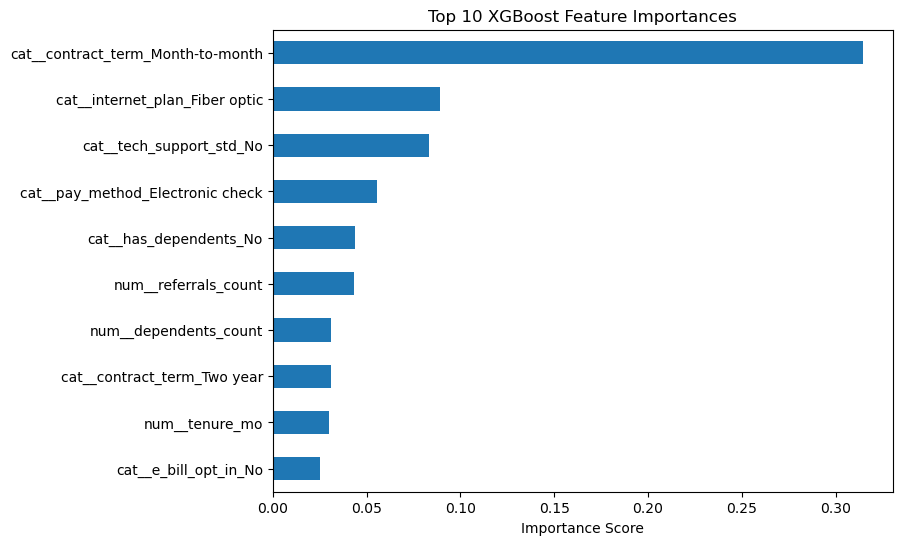

In [87]:
# --- Extract best XGBoost model from your pipeline ---
best_xgb = best_xgb_pipe.named_steps["model"]

# --- Get feature names from preprocessing step ---
pre = best_xgb_pipe.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()

# --- Build importance Series ---
imp = pd.Series(
    best_xgb.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

# Display top 10 in table form
display(imp.head(10))

# --- Plot top 10 feature importances ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
imp.head(10).plot(kind="barh", legend=False)
plt.title("Top 10 XGBoost Feature Importances")
plt.gca().invert_yaxis()  # highest importance at top
plt.xlabel("Importance Score")
plt.show()

SHAP
-------------------------

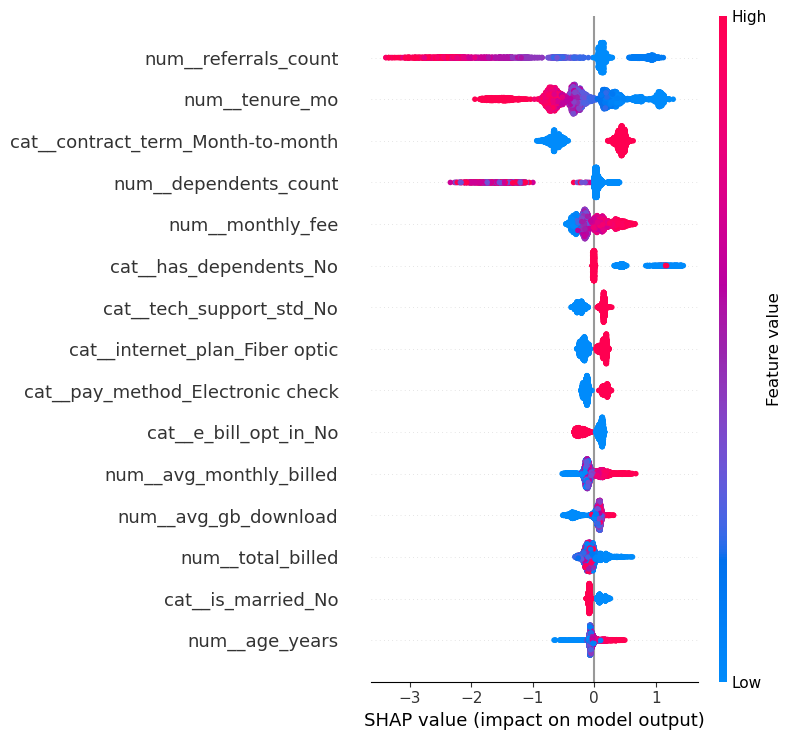

In [34]:
#!pip install shap   
# Install SHAP library if not already installed
 
import shap

# Use the best pipeline from RandomizedSearchCV
best_xgb_pipe = rand_xgb.best_estimator_
best_xgb = best_xgb_pipe.named_steps["model"]

# Preprocessor
pre = best_xgb_pipe.named_steps["preprocess"]

# Transform training data
X_train_enc = pre.transform(X_train)

# Convert sparse → dense if needed
if hasattr(X_train_enc, "toarray"):
    X_train_enc = X_train_enc.toarray()

# Feature names
feature_names = None
if hasattr(pre, "get_feature_names_out"):
    feature_names = pre.get_feature_names_out()

# SHAP explainer for XGBoost
explainer = shap.TreeExplainer(best_xgb)

# SHAP values
shap_values = explainer.shap_values(X_train_enc)

# Beeswarm summary plot
shap.summary_plot(
    shap_values,
    X_train_enc,
    feature_names=feature_names,
    max_display=15,
    show=True
)

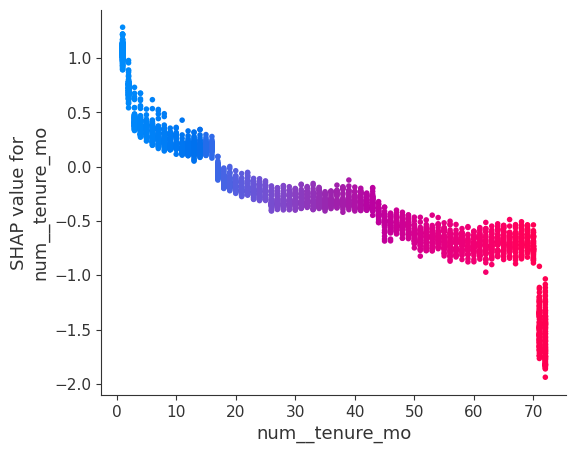

In [38]:
#Dependence plot for one feature
#Tenure (Usually the best choice in churn datasets, strongest churn predictor)
shap.dependence_plot(
    "num__tenure_mo",
    shap_values,
    X_train_enc,
    interaction_index="num__tenure_mo",
    feature_names=feature_names,
    show=True
)

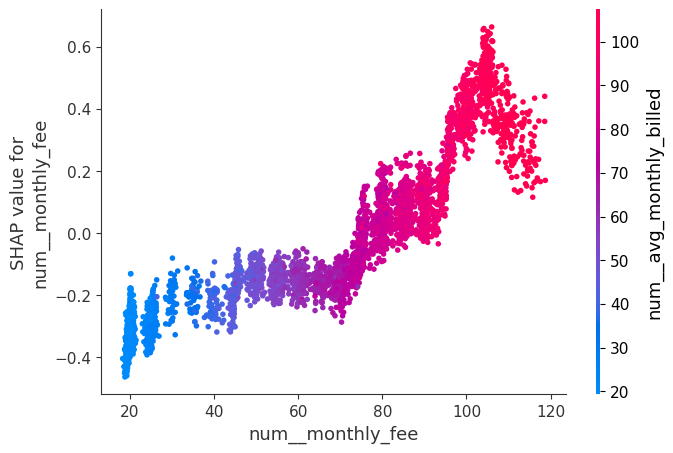

In [41]:
# Dependence plot for one feature
# Num__monthly _fee usually shows a nonlinear pattern

shap.dependence_plot(
    "num__monthly_fee",
    shap_values,
    X_train_enc,
    interaction_index="num__avg_monthly_billed",
    feature_names=feature_names,
    show=True
)

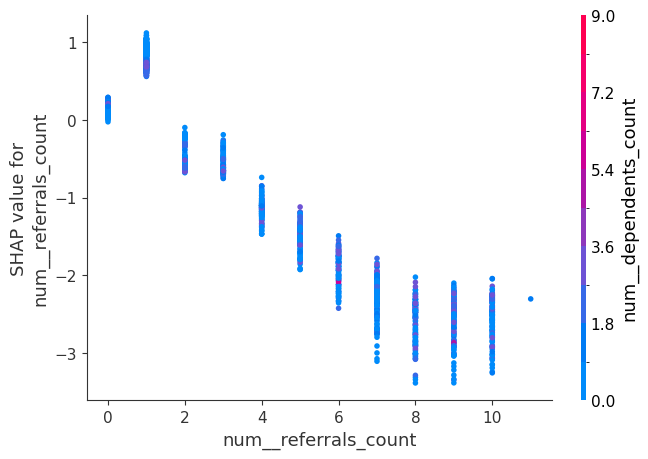

In [42]:
# Dependence plot for one feature
# Num__referrals _count (Top numeric feature!!!!!!)

shap.dependence_plot(
    "num__referrals_count",
    shap_values,
    X_train_enc,
    interaction_index="num__dependents_count",
    feature_names=feature_names,
    show=True
)


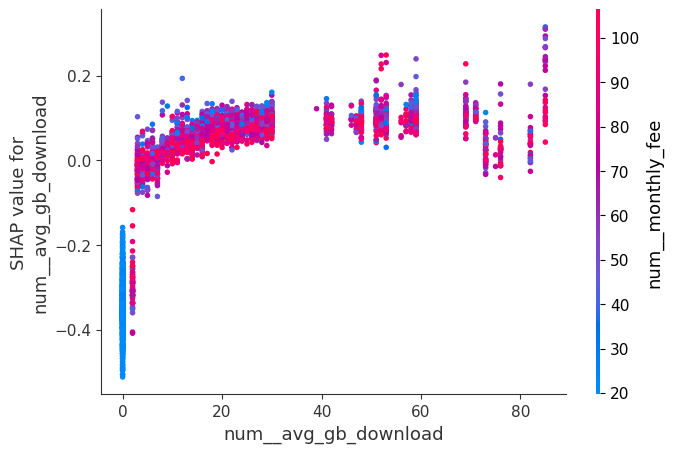

In [43]:
# Dependence plot for one feature
# num__avg_gb_download (Shows interesting behaviors for internet customers

shap.dependence_plot(
    "num__avg_gb_download",
    shap_values,
    X_train_enc,
    interaction_index="num__monthly_fee",
    feature_names=feature_names,
    show=True
)

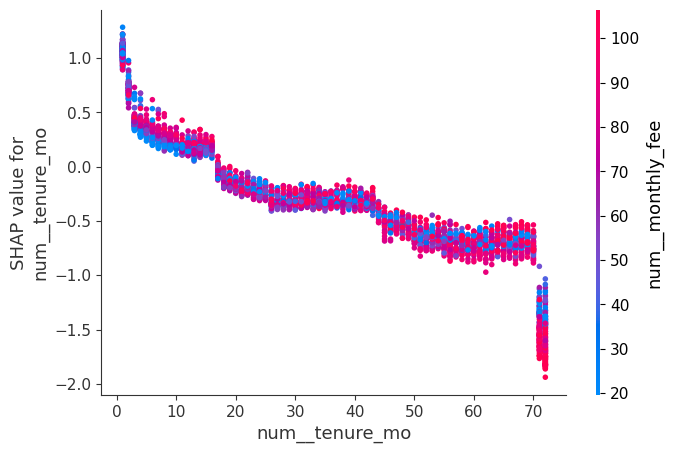

In [39]:
# Dependence plot for one feature, colored by another feature
# Tenure interacting with monthly fee
# short-tenure plus high monthly fee = high churn risk!

shap.dependence_plot(
    "num__tenure_mo",
    shap_values,
    X_train_enc,
    interaction_index="num__monthly_fee",
    feature_names=feature_names,
    show=True
)

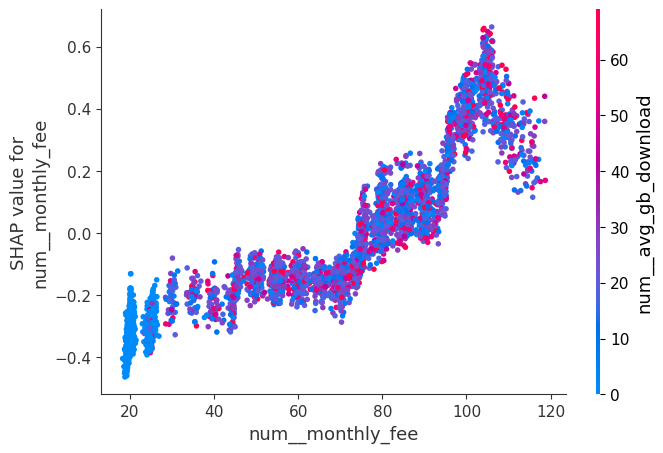

In [44]:
# Dependence plot for one feature, colored by another feature
# Monthly fee interacting with avgerage GB Download
# Shows if heavy internet users behave differently at higher price points!

shap.dependence_plot(
    "num__monthly_fee",
    shap_values,
    X_train_enc,
    interaction_index="num__avg_gb_download",
    feature_names=feature_names,
    show=True
)




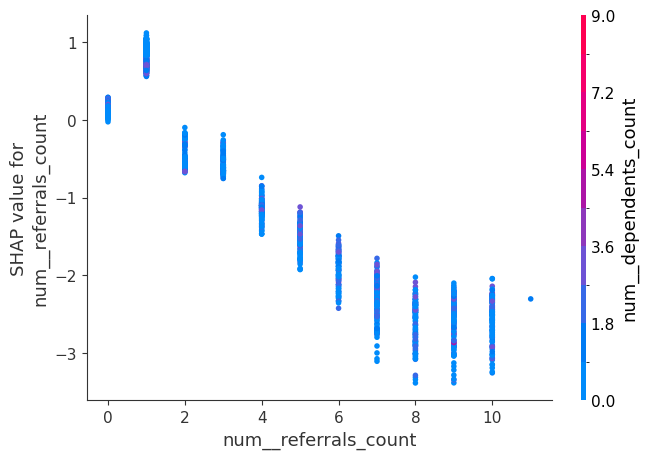

In [45]:
# Dependence plot for one feature, colored by another feature
# Referrals Count interacting with Dependents Count
# Shows referrals and dependents both show up high in shap summary

shap.dependence_plot(
    "num__referrals_count",
    shap_values,
    X_train_enc,
    interaction_index="num__dependents_count",
    feature_names=feature_names,
    show=True
)

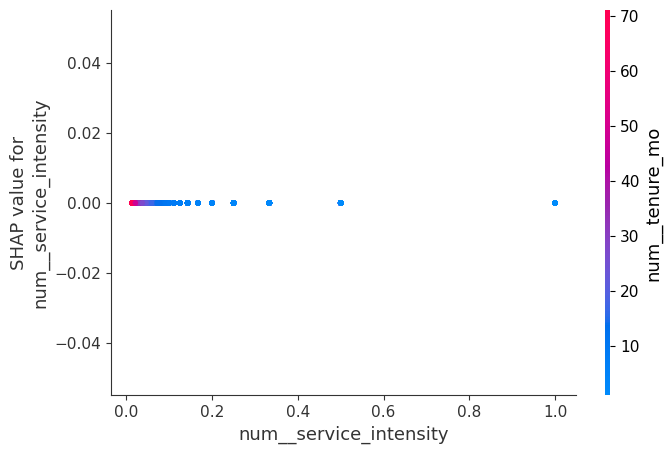

In [101]:
import shap
import matplotlib.pyplot as plt

# Dependence plot for one feature, colored by another feature
# Service Intensity interacting with Tenure
# Shows how service usage and tenure jointly affect churn risk

shap.dependence_plot(
    "num__service_intensity",        # main feature
    shap_values,
    X_train_enc,
    interaction_index="num__tenure_mo",   # color by tenure
    feature_names=feature_names,
    show=True
)

In [46]:
Y_prob = best_pipe.predict_proba(X_test)[:, 1]

C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [47]:
train_vals = set(X_train['stream_music'].unique())
test_vals = set(X_test['stream_music'].unique())

print("Values only in test:", test_vals - train_vals)

for i, col in enumerate(cat_cols):
    print(i, col)


Values only in test: set()
0 acct_ref
1 cust_ref
2 has_dependents
3 internet_plan
4 tech_support_std
5 contract_term
6 e_bill_opt_in
7 pay_method
8 fiscal_qtr
9 gender
10 is_married
11 referred_friend
12 recent_offer
13 internet_tech


In [48]:
print(cat_cols)
for col in cat_cols[:2]:
    print(col, X_train[col].unique(), X_test[col].unique())


['acct_ref', 'cust_ref', 'has_dependents', 'internet_plan', 'tech_support_std', 'contract_term', 'e_bill_opt_in', 'pay_method', 'fiscal_qtr', 'gender', 'is_married', 'referred_friend', 'recent_offer', 'internet_tech']
acct_ref ['ACCT987780' 'ACCT554409' 'ACCT450953' ... 'ACCT133491' 'ACCT661710'
 'ACCT660985'] ['ACCT137060' 'ACCT377887' 'ACCT225259' ... 'ACCT255390' 'ACCT948045'
 'ACCT879880']
cust_ref ['CUST92544408' 'CUST90699522' 'CUST41674852' ... 'CUST51744928'
 'CUST45449474' 'CUST77462311'] ['CUST98188189' 'CUST27977299' 'CUST67302019' ... 'CUST92119940'
 'CUST94248064' 'CUST26819991']


Test ROC-AUC: 0.8501


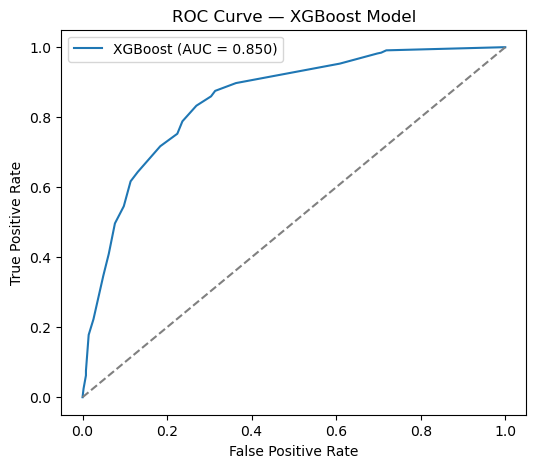

In [50]:
# Needed for Evaluation
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

# Test ROC-AUC
test_auc = roc_auc_score(Y_test, Y_prob)
print("Test ROC-AUC:", round(test_auc, 4))

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {test_auc:.3f})")
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost Model")
plt.legend()
plt.show()


Evaluating model: RandomForestClassifier


C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Random Forest Test ROC-AUC: 0.8629


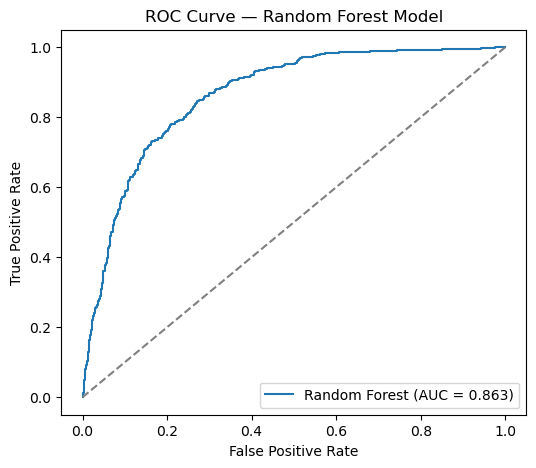

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Identify the model being evaluated
print("Evaluating model:", type(best_rf_pipe.named_steps["model"]).__name__)

# Predict probabilities for the positive class
Y_prob_rf = best_rf_pipe.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
test_auc_rf = roc_auc_score(Y_test, Y_prob_rf)
print("Random Forest Test ROC-AUC:", round(test_auc_rf, 4))

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_prob_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {test_auc_rf:.3f})")
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest Model")
plt.legend()
plt.show()

Evaluating model: DecisionTreeClassifier


C:\Users\miran\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Decision Tree Test ROC-AUC: 0.8501


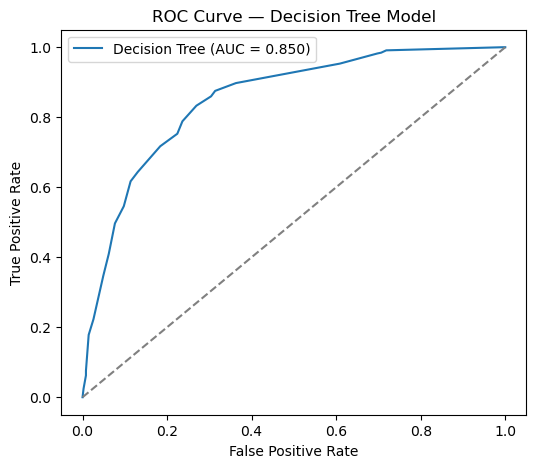

In [56]:
# Identify the model being evaluated
print("Evaluating model:", type(best_dt).__name__)

# Predict probabilities for the positive class
Y_prob_dt = best_pipe.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
test_auc_dt = roc_auc_score(Y_test, Y_prob_dt)
print("Decision Tree Test ROC-AUC:", round(test_auc_dt, 4))

# ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(Y_test, Y_prob_dt)

plt.figure(figsize=(6, 5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {test_auc_dt:.3f})")
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Decision Tree Model")
plt.legend()
plt.show()

Combined ROC Curve — XGBoost vs Random Forest vs Decision Tree
--------------------------

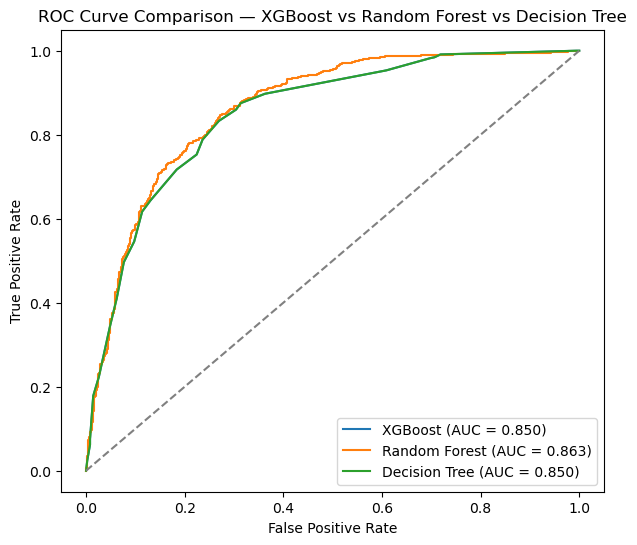

In [57]:
plt.figure(figsize=(7, 6))

# XGBoost
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {test_auc:.3f})")

# Random Forest
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {test_auc_rf:.3f})")

# Decision Tree
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {test_auc_dt:.3f})")

# Random baseline
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — XGBoost vs Random Forest vs Decision Tree")
plt.legend()
plt.show()

Evaluating model: Pipeline
CatBoost Test ROC-AUC: 0.8963


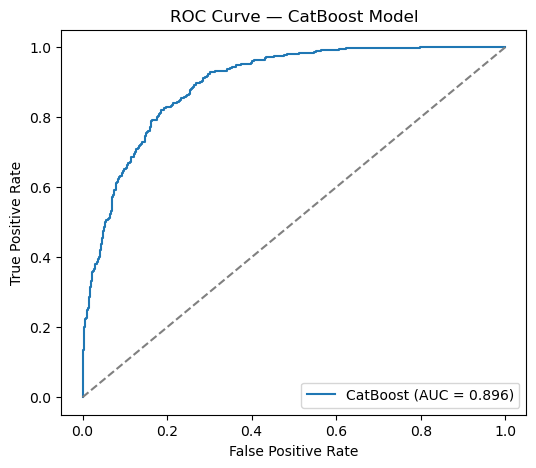

In [89]:
# Identify the model being evaluated
print("Evaluating model:", type(best_cat).__name__)

# Predict probabilities for the positive class
Y_prob_cat = best_cat.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
test_auc_cat = roc_auc_score(Y_test, Y_prob_cat)
print("CatBoost Test ROC-AUC:", round(test_auc_cat, 4))

# ROC Curve
fpr_cat, tpr_cat, _ = roc_curve(Y_test, Y_prob_cat)

plt.figure(figsize=(6, 5))
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {test_auc_cat:.3f})")
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — CatBoost Model")
plt.legend()
plt.show()

C:\Users\miran\AppData\Local\Temp\ipykernel_28136\2285954277.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="left_flag", y="tenure_mo", palette="Set2")


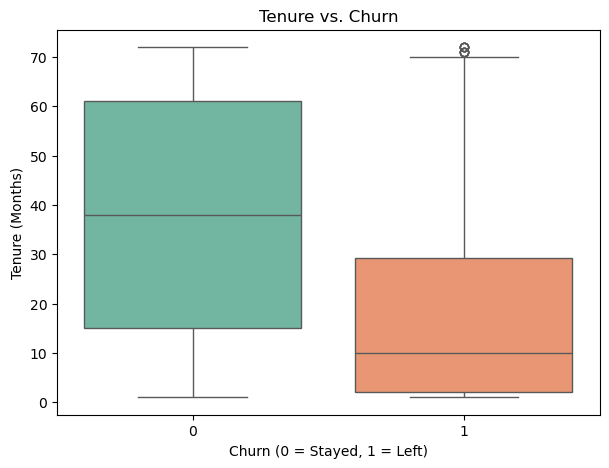

In [95]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="left_flag", y="tenure_mo", palette="Set2")

plt.title("Tenure vs. Churn")
plt.xlabel("Churn (0 = Stayed, 1 = Left)")
plt.ylabel("Tenure (Months)")
plt.show()

C:\Users\miran\AppData\Local\Temp\ipykernel_28136\1660845772.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="left_flag", y="monthly_fee", palette="Set3")


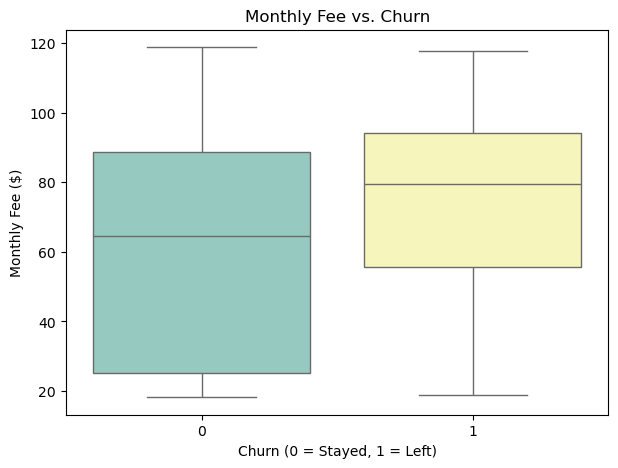

In [96]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="left_flag", y="monthly_fee", palette="Set3")

plt.title("Monthly Fee vs. Churn")
plt.xlabel("Churn (0 = Stayed, 1 = Left)")
plt.ylabel("Monthly Fee ($)")
plt.show()

C:\Users\miran\AppData\Local\Temp\ipykernel_28136\1386705460.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="left_flag", y="service_intensity", palette="Set1")


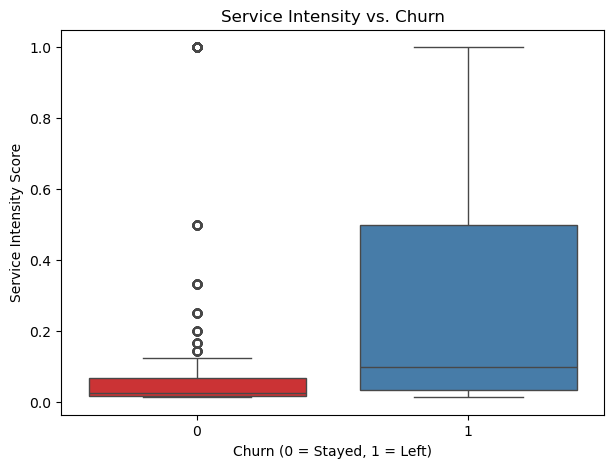

In [99]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="left_flag", y="service_intensity", palette="Set1")

plt.title("Service Intensity vs. Churn")
plt.xlabel("Churn (0 = Stayed, 1 = Left)")
plt.ylabel("Service Intensity Score")
plt.show()

Cleaned and single-block CatBoost Model (tuning + Fitting + best model)
-------------------

In [58]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Use your actual categorical column names
cat_features = cat_cols   # you already defined this earlier

# Pipeline with CatBoost (no preprocessing needed)
cat_pipe = Pipeline([
    ("model", CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=99,
        verbose=0,
        allow_writing_files=False
    ))
])

# Parameter grid for tuning
param_grid = {
    "model__depth": [4, 6, 8],
    "model__learning_rate": [0.03, 0.1],
    "model__iterations": [400, 800],
    "model__l2_leaf_reg": [1, 3, 10]
}

# Grid search
cat_cv = GridSearchCV(
    estimator=cat_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True
)

# Fit with categorical features
cat_cv.fit(X_train, Y_train, model__cat_features=cat_features)

# Best model
best_cat = cat_cv.best_estimator_
print("Best CatBoost Params:", cat_cv.best_params_)

Best CatBoost Params: {'model__depth': 4, 'model__iterations': 400, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.03}


In [59]:
# Predict probabilities

Y_prob_cat = best_cat.predict_proba(X_test)[:, 1]

In [60]:
# Compute ROC_AUD

test_auc_cat = roc_auc_score(Y_test, Y_prob_cat)
print("CatBoost Test ROC-AUC:", round(test_auc_cat, 4))

CatBoost Test ROC-AUC: 0.8963


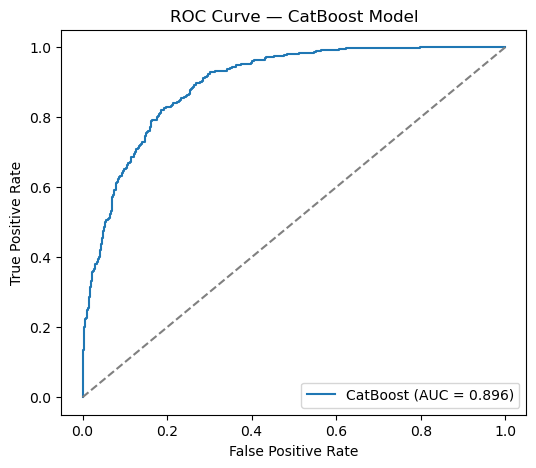

In [61]:
# Plot the ROC curve

fpr_cat, tpr_cat, _ = roc_curve(Y_test, Y_prob_cat)

plt.figure(figsize=(6, 5))
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {test_auc_cat:.3f})")
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — CatBoost Model")
plt.legend()
plt.show()

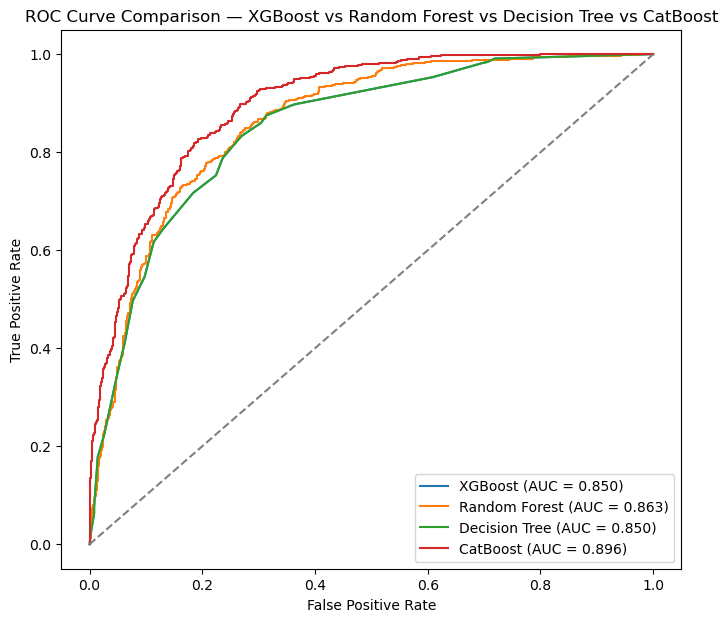

In [63]:
# All four model combined ROC curve 

plt.figure(figsize=(8, 7))

# XGBoost
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {test_auc:.3f})")

# Random Forest
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {test_auc_rf:.3f})")

# Decision Tree
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {test_auc_dt:.3f})")

# CatBoost
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {test_auc_cat:.3f})")

# Baseline
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — XGBoost vs Random Forest vs Decision Tree vs CatBoost")
plt.legend()
plt.show()

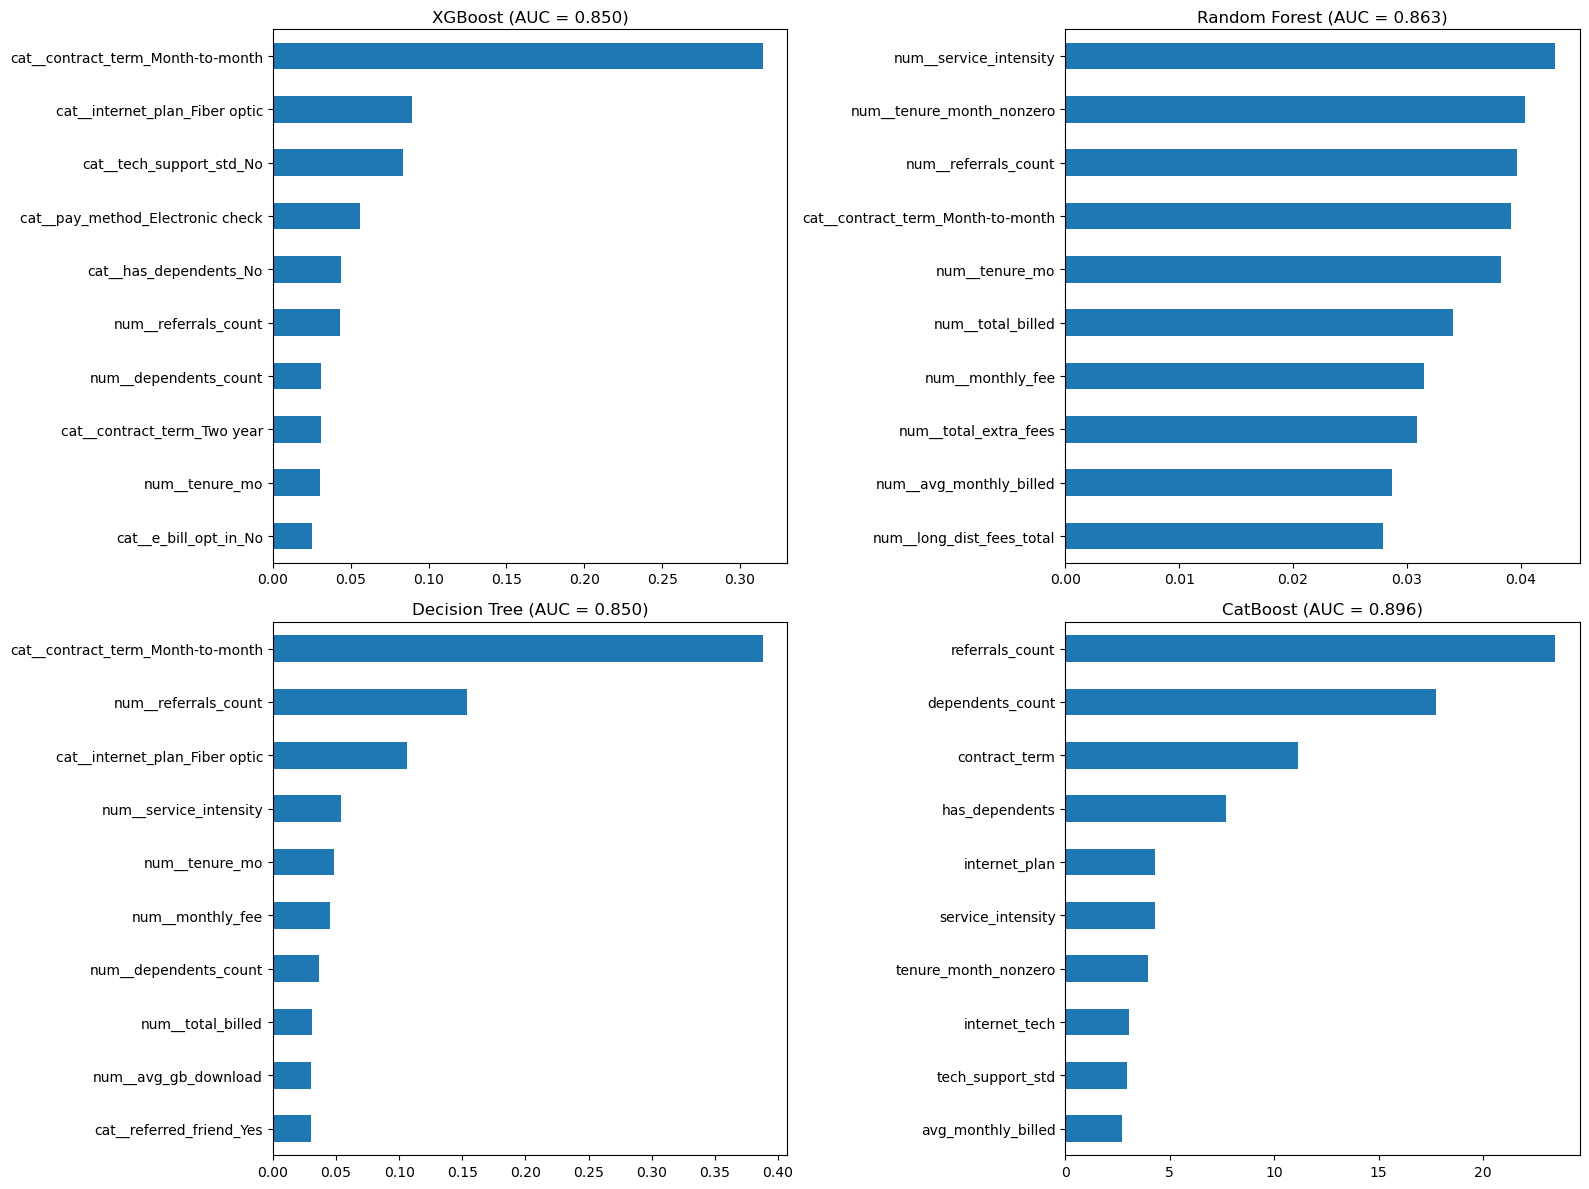

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# -----------------------------
# 1. XGBoost Feature Importances
# -----------------------------
best_xgb = best_xgb_pipe.named_steps["model"]
pre_xgb = best_xgb_pipe.named_steps["preprocess"]
xgb_features = pre_xgb.get_feature_names_out()

xgb_imp = pd.Series(best_xgb.feature_importances_, index=xgb_features).sort_values(ascending=False)
xgb_imp.head(10).plot(kind="barh", ax=axes[0], title=f"XGBoost (AUC = {test_auc:.3f})")
axes[0].invert_yaxis()

# -----------------------------
# 2. Random Forest Feature Importances
# -----------------------------
best_rf = best_rf_pipe.named_steps["model"]
pre_rf = best_rf_pipe.named_steps["preprocess"]
rf_features = pre_rf.get_feature_names_out()

rf_imp = pd.Series(best_rf.feature_importances_, index=rf_features).sort_values(ascending=False)
rf_imp.head(10).plot(kind="barh", ax=axes[1], title=f"Random Forest (AUC = {test_auc_rf:.3f})")
axes[1].invert_yaxis()

# -----------------------------
# 3. Decision Tree Feature Importances
# -----------------------------
best_dt = best_pipe.named_steps["model"]
pre_dt = best_pipe.named_steps["preprocess"]
dt_features = pre_dt.get_feature_names_out()

dt_imp = pd.Series(best_dt.feature_importances_, index=dt_features).sort_values(ascending=False)
dt_imp.head(10).plot(kind="barh", ax=axes[2], title=f"Decision Tree (AUC = {test_auc_dt:.3f})")
axes[2].invert_yaxis()

# -----------------------------
# 4. CatBoost Feature Importances
# -----------------------------
best_cat_model = best_cat.named_steps["model"]

cat_imp = pd.Series(
    best_cat_model.get_feature_importance(),
    index=X_train.columns
).sort_values(ascending=False)

cat_imp.head(10).plot(kind="barh", ax=axes[3], title=f"CatBoost (AUC = {test_auc_cat:.3f})")
axes[3].invert_yaxis()

# -----------------------------
# Layout adjustments
# -----------------------------
plt.tight_layout()
plt.show()

Clustering and K-means
---------------------

All features must be numeric so you have to convert categorical data to numeric and you have to use scaling because k-means is distance-based. 

--K-Means finds natural customer segments--

--It doesn't predict churn--

--It can help understand patterns in the customer base--

--"Bonus Analysis"


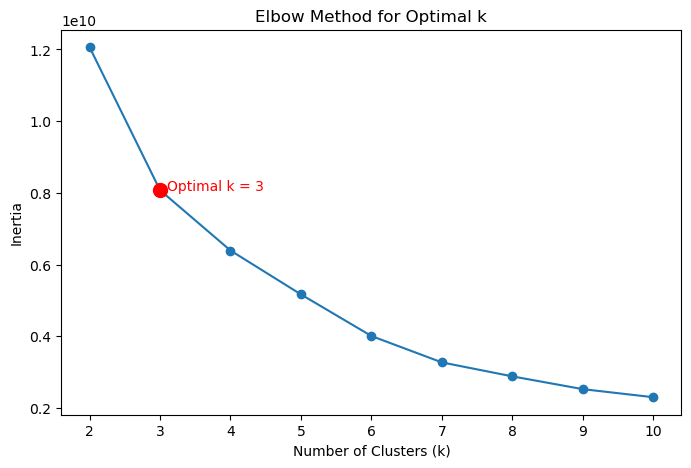

In [74]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scale your data using your preprocessing pipeline
X_scaled = preprocess.fit_transform(X)

inertias = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

optimal_k = 3  # based on your elbow values

plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")

# --- Annotate the optimal point ---
opt_x = optimal_k
opt_y = inertias[K.index(optimal_k)]

plt.scatter(opt_x, opt_y, color='red', s=100, zorder=5)
plt.text(opt_x + 0.1, opt_y, f"Optimal k = {optimal_k}", color='red')

plt.show()

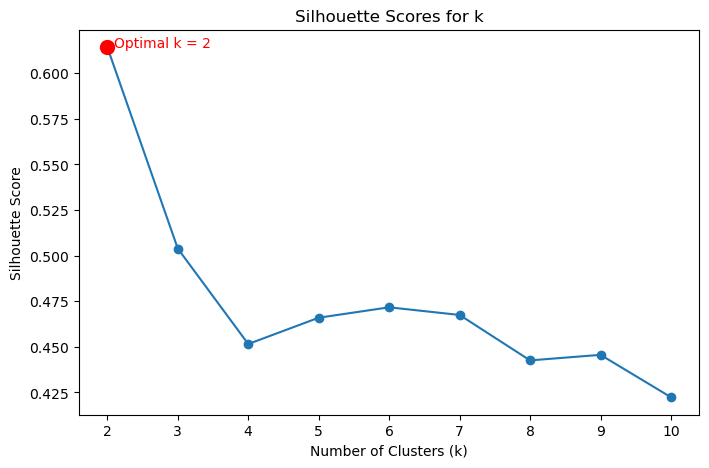

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


#Sihouette Score measures how well-separated the clusters are, looking for the PEAK sihouette score it usually your best k
# Scale your data using your preprocessing pipeline
X_scaled = preprocess.fit_transform(X)

sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

# Find optimal k automatically
optimal_k_sil = K[sil_scores.index(max(sil_scores))]
optimal_sil_value = max(sil_scores)

plt.figure(figsize=(8,5))
plt.plot(K, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for k")

# --- Annotate the optimal silhouette point ---
plt.scatter(optimal_k_sil, optimal_sil_value, color='red', s=100, zorder=5)
plt.text(optimal_k_sil + 0.1, optimal_sil_value,
         f"Optimal k = {optimal_k_sil}",
         color='red')

plt.show()

In [81]:
# --- K-Means Clustering (k = 3) with zero-variance features removed ONLY for clustering ---

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Make a copy so the original df stays untouched
df_cluster = df.copy()

# 2. Identify columns that are entirely zero (no variation)
zero_cols = [
    col for col in df_cluster.columns
    if df_cluster[col].nunique() == 1 and df_cluster[col].unique()[0] == 0
]

print("Columns removed from clustering (all zeros):")
print(zero_cols)

# 3. Drop only the zero-variance columns that actually exist
df_cluster = df_cluster.drop(columns=[c for c in zero_cols if c in df_cluster.columns])

# 4. Select numeric features for clustering
X_cluster = df_cluster.select_dtypes(include=['int64', 'float64'])

# 5. Scale using StandardScaler (NOT your supervised pipeline)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 6. Fit K-Means with k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 7. Add cluster labels back to BOTH dataframes
df["cluster"] = clusters
df_cluster["cluster"] = clusters

# 8. Print cluster sizes
print("\nCluster Sizes:")
print(df["cluster"].value_counts())

# 9. Print cluster means using the CLEANED clustering DataFrame
print("\nCluster Means (cleaned):")
display(df_cluster.groupby("cluster").mean(numeric_only=True))

Columns removed from clustering (all zeros):
['home_phone', 'multi_line', 'add_on_security', 'add_on_backup', 'add_on_protection', 'stream_tv', 'stream_movies', 'premium_support', 'stream_music', 'unlimited_data_opt', 'count_of_streaming_services', 'count_of_add_on_services']

Cluster Sizes:
cluster
1    2514
2    1613
0    1501
Name: count, dtype: int64

Cluster Means (cleaned):


,tenure_mo,monthly_fee,total_billed,left_flag,age_years,dependents_count,referrals_count,avg_long_dist_fee,avg_gb_download,refunds_total,...,long_dist_fees_total,tenure_month_nonzero,avg_monthly_billed,avg_monthly_extra_fees,avg_monthly_long_dist_fee,total_extra_fees,has_internet,count_of_reg_services,total_services,service_intensity
cluster,,,,,,,,,,,,,,,,,,,,,
0,55.001332,77.916656,4297.250600,0.141905,47.131912,0.520320,2.780813,35.955656,21.789474,1.950520,...,1934.376089,55.001332,77.877516,0.190875,35.955656,1980.025283,1.0,1.0,1.0,0.019888
1,9.610581,55.556106,521.431146,0.434368,46.404932,0.332538,0.868337,23.825095,17.912888,1.204137,...,240.812239,9.610581,55.541770,0.866717,23.825095,268.559372,1.0,1.0,1.0,0.323770
2,47.205828,67.054898,3178.120273,0.118413,46.707378,0.616863,2.877867,9.049492,23.055797,2.927805,...,416.506795,47.205828,67.090292,0.245870,9.049492,434.930124,1.0,1.0,1.0,0.025242


Inspect cluster centers (means)
------------------
K-means centers are the mean values of each feature within each cluster (in the space used to fit the model).

In [82]:
# --- K-Means Clustering (k = 3) with zero-variance features removed ONLY for clustering ---

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Make a copy so the original df stays untouched
df_cluster = df.copy()

# 2. Identify columns that are entirely zero (no variation)
zero_cols = [
    col for col in df_cluster.columns
    if df_cluster[col].nunique() == 1 and df_cluster[col].unique()[0] == 0
]

print("Columns removed from clustering (all zeros):")
print(zero_cols)

# 3. Drop only the zero-variance columns that actually exist
df_cluster = df_cluster.drop(columns=[c for c in zero_cols if c in df_cluster.columns])

# 4. Select numeric features for clustering
X_cluster = df_cluster.select_dtypes(include=['int64', 'float64'])

# 5. Scale using StandardScaler (NOT your supervised pipeline)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 6. Fit K-Means with k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 7. Add cluster labels back to BOTH dataframes
df["cluster"] = clusters
df_cluster["cluster"] = clusters

# 8. Print cluster sizes
print("\nCluster Sizes:")
print(df["cluster"].value_counts())

# 9. Print cluster means using the CLEANED clustering DataFrame
print("\nCluster Means (cleaned):")
display(df_cluster.groupby("cluster").mean(numeric_only=True))

# 10. Create cluster centers DataFrame using the correct columns
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X_cluster.columns
)

print("\nCluster Centers (scaled space):")
display(centers)

Columns removed from clustering (all zeros):
['home_phone', 'multi_line', 'add_on_security', 'add_on_backup', 'add_on_protection', 'stream_tv', 'stream_movies', 'premium_support', 'stream_music', 'unlimited_data_opt', 'count_of_streaming_services', 'count_of_add_on_services']

Cluster Sizes:
cluster
1    2514
2    1613
0    1501
Name: count, dtype: int64

Cluster Means (cleaned):


,tenure_mo,monthly_fee,total_billed,left_flag,age_years,dependents_count,referrals_count,avg_long_dist_fee,avg_gb_download,refunds_total,...,long_dist_fees_total,tenure_month_nonzero,avg_monthly_billed,avg_monthly_extra_fees,avg_monthly_long_dist_fee,total_extra_fees,has_internet,count_of_reg_services,total_services,service_intensity
cluster,,,,,,,,,,,,,,,,,,,,,
0,55.001332,77.916656,4297.250600,0.141905,47.131912,0.520320,2.780813,35.955656,21.789474,1.950520,...,1934.376089,55.001332,77.877516,0.190875,35.955656,1980.025283,1.0,1.0,1.0,0.019888
1,9.610581,55.556106,521.431146,0.434368,46.404932,0.332538,0.868337,23.825095,17.912888,1.204137,...,240.812239,9.610581,55.541770,0.866717,23.825095,268.559372,1.0,1.0,1.0,0.323770
2,47.205828,67.054898,3178.120273,0.118413,46.707378,0.616863,2.877867,9.049492,23.055797,2.927805,...,416.506795,47.205828,67.090292,0.245870,9.049492,434.930124,1.0,1.0,1.0,0.025242



Cluster Centers (scaled space):


,tenure_mo,monthly_fee,total_billed,left_flag,age_years,dependents_count,referrals_count,avg_long_dist_fee,avg_gb_download,refunds_total,...,long_dist_fees_total,tenure_month_nonzero,avg_monthly_billed,avg_monthly_extra_fees,avg_monthly_long_dist_fee,total_extra_fees,has_internet,count_of_reg_services,total_services,service_intensity
0,0.918317,0.435568,0.885489,-0.280270,0.025574,0.059058,0.272756,0.848295,0.067398,0.007028,...,1.422426,0.918317,0.433141,-0.096518,0.848295,1.422283,0.0,0.0,0.0,-0.488208
1,-0.933155,-0.308916,-0.780763,0.380764,-0.016645,-0.135170,-0.359413,0.064631,-0.125078,-0.086982,...,-0.598461,-0.933155,-0.308302,0.108666,0.064631,-0.593041,0.0,0.0,0.0,0.591771
2,0.601949,0.076849,0.394643,-0.333497,0.002183,0.156018,0.307164,-0.890233,0.132506,0.129221,...,-0.389523,0.601949,0.078149,-0.079794,-0.890233,-0.397850,0.0,0.0,0.0,-0.469345


Box Plot Side by Side
-----------------
Tenure_mo, Monthly_fee, and Total_billed

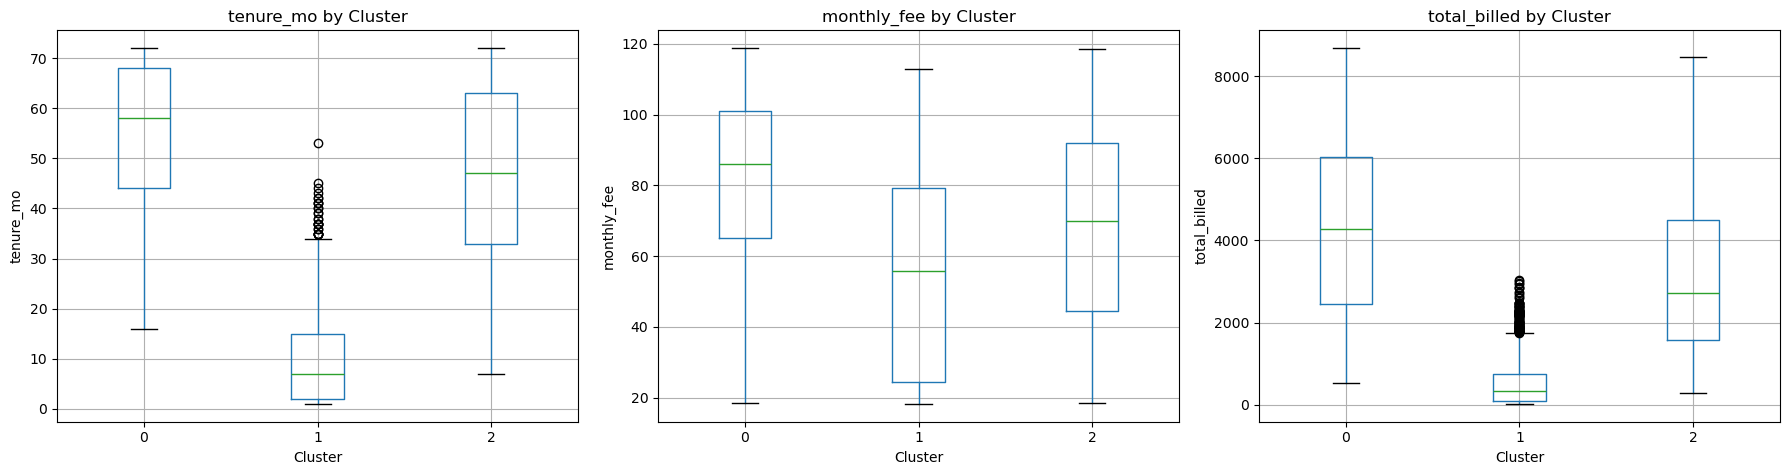

In [85]:
import matplotlib.pyplot as plt

# Variables to visualize
variables = ["tenure_mo", "monthly_fee", "total_billed"]

# Validate variables exist
missing = [v for v in variables if v not in df_cluster.columns]
if missing:
    raise KeyError(f"Missing variables in df_cluster: {missing}")

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, var in zip(axes, variables):
    df_cluster.boxplot(column=var, by='cluster', ax=ax)
    ax.set_title(f"{var} by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(var)

# Remove the automatic super-title
plt.suptitle("")
plt.tight_layout()
plt.show()

Visualize clusters in 2D with PCA
-----------------

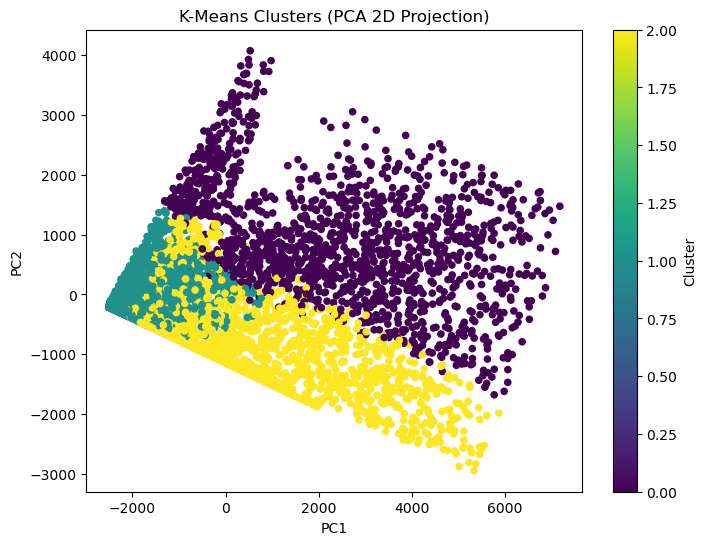

array([0.87366946, 0.12582917])

In [86]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use the same numeric features used for clustering
X = X_cluster.values   # X_cluster came from df_cluster.select_dtypes(...)

# Run PCA
pca = PCA(n_components=2, random_state=943)
X2 = pca.fit_transform(X)

# Plot PCA projection
plt.figure(figsize=(8,6))
plt.scatter(X2[:, 0], X2[:, 1], c=df_cluster['cluster'], cmap='viridis', s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clusters (PCA 2D Projection)')
plt.colorbar(label='Cluster')
plt.show()

# Show explained variance
pca.explained_variance_ratio_

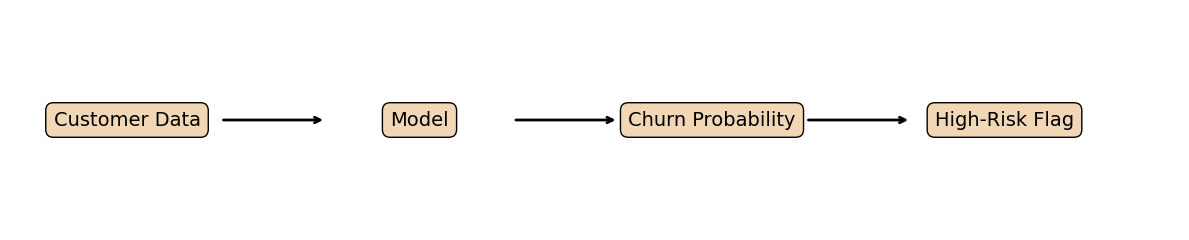

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 2.5))

# Turn off axes
ax.axis('off')

# Box style
box = dict(boxstyle='round,pad=0.4', fc='#f2d7b6', ec='black')

# Text boxes spaced evenly
ax.text(0.1, 0.5, 'Customer Data', ha='center', va='center', fontsize=14, bbox=box)
ax.text(0.35, 0.5, 'Model', ha='center', va='center', fontsize=14, bbox=box)
ax.text(0.6, 0.5, 'Churn Probability', ha='center', va='center', fontsize=14, bbox=box)
ax.text(0.85, 0.5, 'High-Risk Flag', ha='center', va='center', fontsize=14, bbox=box)

# Arrows between boxes
arrow = dict(arrowstyle='->', lw=2)

ax.annotate('', xy=(0.27, 0.5), xytext=(0.18, 0.5), arrowprops=arrow)
ax.annotate('', xy=(0.52, 0.5), xytext=(0.43, 0.5), arrowprops=arrow)
ax.annotate('', xy=(0.77, 0.5), xytext=(0.68, 0.5), arrowprops=arrow)

plt.tight_layout()
plt.show()